In [1]:
# setup for Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn

In [4]:
root_dir = '/content/gdrive/MyDrive/oc_projet_7'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Get data

In [5]:
test_mode = True
test_mode_samples = 1000

# load original df
data_path = root_dir + '/data/' + 'training.1600000.processed.noemoticon.csv'
column_names = ['label', 'id', 'date', 'flag', 'user', 'text']
to_keep = ['text', 'label']

df = pd.read_csv(data_path, encoding='latin-1', header=None, names=column_names)
if test_mode:
    # keep only a sample to increase computation speed
    df = df.sample(n=test_mode_samples, random_state=0)

df = df[to_keep]
df

,text,label
557138,wants to compete! i want hard competition! i w...,0
349381,It seems we are stuck on the ground in Amarill...,0
182051,where the f are my pinking shears? rarararrrar...,0
571236,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...,0
1339637,@ reply me pls,4
...,...,...
235274,Sitting with a temper bed cover over my bed Re...,0
122382,ouch just got a nasty burn,0
419988,Lost my headphones tonight.. Lame 1 week til...,0
241280,THE HILLS SEASON FNALE...tonight,0


## BERT test

In [6]:
model_name = 'bert-base-uncased'

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

In [7]:
sample_txt = "Replace me by any text you'd like."
tokens = tokenizer.tokenize(sample_txt)
tokens

['replace', 'me', 'by', 'any', 'text', 'you', "'", 'd', 'like', '.']

In [8]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012]

In [9]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


84 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


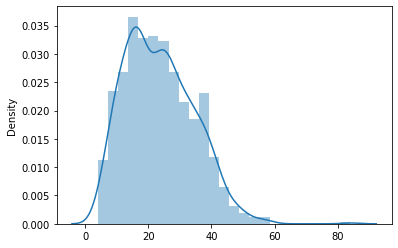

In [10]:
token_lens = []
for text in df['text']:
    tokens = tokenizer.encode(text)
    token_lens.append(len(tokens))

max_len = max(token_lens)
print(max_len, '\n')
sns.distplot(token_lens)

In [11]:
encoding = tokenizer.encode_plus(sample_txt, 
                                 max_length=max_len, 
                                 add_special_tokens=True, 
                                 padding='max_length', 
                                 return_attention_mask=True, 
                                 return_token_type_ids=False, 
                                 return_tensors='pt')

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [12]:
encoding['input_ids']

tensor([[ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [13]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
from transformers import BertModel
bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
bert_output = bert_model(encoding['input_ids'], 
                         attention_mask=encoding['attention_mask'])
last_hidden_state, pooled_output = bert_output.last_hidden_state, bert_output.pooler_output

print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 84, 768])
torch.Size([1, 768])


In [16]:
bert_model.config.hidden_size

768

## Create Dataset

In [17]:
class_names = ['negative', 'positive']
nb_classes = len(class_names)
print(nb_classes)

2


In [18]:
# convert labels: negative is 0, positive is 1
y_origin = np.array(df['label'])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_origin)
print(le.classes_)

y = le.transform(y_origin)
print(np.unique(y))

[0 4]
[0 1]


In [19]:
df['label'] = y
df

,text,label
557138,wants to compete! i want hard competition! i w...,0
349381,It seems we are stuck on the ground in Amarill...,0
182051,where the f are my pinking shears? rarararrrar...,0
571236,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...,0
1339637,@ reply me pls,1
...,...,...
235274,Sitting with a temper bed cover over my bed Re...,0
122382,ouch just got a nasty burn,0
419988,Lost my headphones tonight.. Lame 1 week til...,0
241280,THE HILLS SEASON FNALE...tonight,0


In [20]:
from torch.utils import data

class TweetDataset(data.Dataset):

    def __init__(self, tweet, target, tokenizer, max_len, nb_classes):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])

        encoding = tokenizer.encode_plus(tweet, 
                                         max_length=self.max_len, 
                                         add_special_tokens=True, 
                                         padding='max_length', 
                                         return_attention_mask=True, 
                                         return_token_type_ids=False, 
                                         return_tensors='pt'
                                        )

        return {'tweet_text': tweet, 
                'input_ids': encoding['input_ids'].flatten(), 
                'attention_mask': encoding['attention_mask'].flatten(), 
                'targets': torch.tensor(self.target[item], dtype=torch.long)
                }


In [21]:
from sklearn.model_selection import train_test_split
df_train, df_val_test = train_test_split(df, test_size=0.2, random_state=0)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=0)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(800, 2)
(100, 2)
(100, 2)


In [22]:
def make_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(tweet=df['text'].to_numpy(), 
                           target=df['label'].to_numpy(), 
                           tokenizer=tokenizer, 
                           max_len=max_len, 
                           nb_classes=nb_classes)
    
    return data.DataLoader(dataset, batch_size=batch_size)

In [23]:
batch_size = 8

train_data_loader = make_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = make_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = make_data_loader(df_test, tokenizer, max_len, batch_size)

In [24]:
# look at the first train batch for testing
batch = next(iter(train_data_loader))
batch.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(batch['input_ids'].shape)
print(batch['attention_mask'].shape)
print(batch['targets'].shape)

torch.Size([8, 84])
torch.Size([8, 84])
torch.Size([8])


## Create classifier

In [26]:
from torch import nn

class Classifier(nn.Module):

    def __init__(self, nb_classes):
        super(Classifier, self).__init__()

        self.bert = BertModel.from_pretrained(model_name)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, nb_classes)
        self.softmax = nn.Softmax()
    
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, 
                                attention_mask=attention_mask)

        fc = self.linear1(bert_output.pooler_output)
        return fc
        

In [27]:
model = Classifier(nb_classes=nb_classes)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

# raw output
output = model(input_ids, attention_mask)
print(output)

# output with softmax
print('\n')
print(nn.functional.softmax(output, dim=1))

tensor([[ 0.6801, -0.3145],
        [ 0.7442, -0.3081],
        [ 0.8772, -0.4958],
        [ 0.7030, -0.4431],
        [ 0.4302, -0.2711],
        [ 0.9620, -0.4487],
        [ 1.0329, -0.5124],
        [ 1.1072, -0.4298]], grad_fn=<AddmmBackward0>)


tensor([[0.7300, 0.2700],
        [0.7412, 0.2588],
        [0.7979, 0.2021],
        [0.7588, 0.2412],
        [0.6685, 0.3315],
        [0.8039, 0.1961],
        [0.8242, 0.1758],
        [0.8230, 0.1770]], grad_fn=<SoftmaxBackward0>)


## Training

In [29]:
epochs = 10

In [30]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=0.00002, correct_bias=False)

total_steps = len(train_data_loader) * epochs

from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

loss_func = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
def train_epoch(model, 
                data_loader, 
                loss_func, 
                optimizer, 
                scheduler, 
                n_exemples, 
                device):
    
    model = model.train()
    
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask)

        _, preds = torch.max(output, dim=1)
        loss = loss_func(outputs, targets)
        correct_predictions += torch.sum(preds==targets).detach().cpu().numpy()
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)   # gradient clipping
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        accuracy = float(correct_predictions) / n_exemples
        mean_loss = np.mean(losses)
        return accuracy, mean_loss

In [32]:
def eval_model(model, 
               data_loader, 
               loss_func, 
               n_exemples, 
               device):
    
    model = model.eval()
    
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask)
            
            _, preds = torch.max(output, dim=1)
            loss = loss_func(outputs, targets)
            correct_predictions += torch.sum(preds==targets).detach().cpu().numpy()
            losses.append(loss.item())

            accuracy = float(correct_predictions) / n_exemples
            mean_loss = np.mean(losses)
            return accuracy, mean_loss

In [33]:
%%time

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):
    print(f'epoch {epoch+1}/{epochs}')
    print('-'*10)

    train_acc, train_loss = train_epoch(model, 
                                        train_data_loader, 
                                        loss_func, 
                                        optimizer, 
                                        scheduler, 
                                        len(df_train), 
                                        device)
    print(f'     train loss: {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, 
                                   val_data_loader, 
                                   loss_func, 
                                   len(df_val), 
                                   device)
    print(f'validation loss: {val_loss}, accuracy {val_acc}', '\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    '''
    if val_acc > best_accuracy:
        #torch.save(model, 'model.pth')
        best_accuracy = val_acc
    '''
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

epoch 1/10
----------
     train loss: 0.9477003216743469, accuracy 0.00375
validation loss: 0.7593686580657959, accuracy 0.04 

epoch 2/10
----------
     train loss: 0.5820311903953552, accuracy 0.00375
validation loss: 0.6887666583061218, accuracy 0.04 

epoch 3/10
----------
     train loss: 0.5311020016670227, accuracy 0.00375
validation loss: 0.6168134212493896, accuracy 0.04 

epoch 4/10
----------
     train loss: 0.3326573967933655, accuracy 0.00375
validation loss: 0.5768979787826538, accuracy 0.04 

epoch 5/10
----------
     train loss: 0.21785855293273926, accuracy 0.00375
validation loss: 0.5489335656166077, accuracy 0.04 

epoch 6/10
----------
     train loss: 0.16727036237716675, accuracy 0.00375
validation loss: 0.605336606502533, accuracy 0.04 

epoch 7/10
----------
     train loss: 0.16564461588859558, accuracy 0.00375
validation loss: 0.7461456656455994, accuracy 0.04 

epoch 8/10
----------
     train loss: 0.10483091324567795, accuracy 0.00375
validation loss: 0

In [34]:
save_model = True


if save_model:
    # choose model save path and save model
    i = 0
    model_path = root_dir + '/data/models/' + model_name + '_' + str(i) + '.pt'

    while os.path.exists(model_path):
        i += 1
        model_path = root_dir + '/data/models/' + model_name + '_' + str(i) + '.pt'

    print('model path:\n' + model_path + '\n')
    torch.save(model.state_dict(), model_path)

    # load model
    model = Classifier(len(class_names))
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

model path:
/content/gdrive/MyDrive/oc_projet_7/data/models/bert-base-uncased_0.pt



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


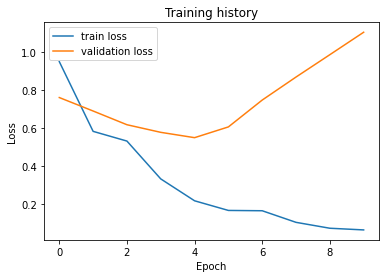

In [35]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

(0.0, 1.0)

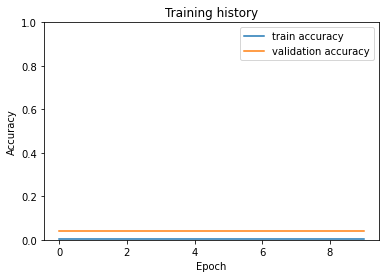

In [36]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## Evaluation

In [37]:
# test set results
test_acc, _ = eval_model(model,
                         test_data_loader,
                         loss_func,
                         len(df_test), 
                         device)

test_acc

0.05

In [38]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d['tweet_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = nn.functional.softmax(outputs, dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

            predictions = torch.stack(predictions).cpu()
            prediction_probs = torch.stack(prediction_probs).cpu()
            real_values = torch.stack(real_values).cpu()
            return tweet_texts, predictions, prediction_probs, real_values

In [39]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model,
                                                               test_data_loader)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.62      1.00      0.77         5
    positive       0.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


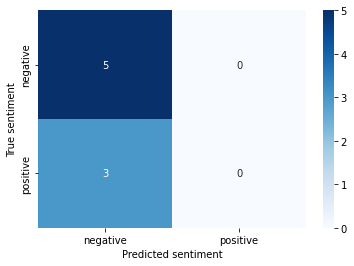

In [40]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [41]:
idx = 2

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [42]:
from textwrap import wrap
print('\n'.join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

@al_ice no i havent  not yet. hehe. any good ones in CT?

True sentiment: negative


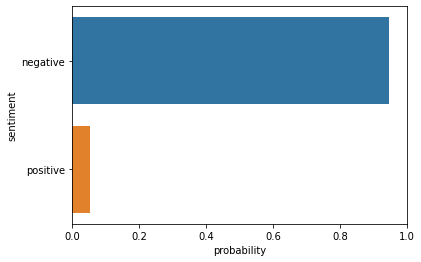

In [43]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Predict on one tweet:

In [44]:
review_text = 'I am going to cry if this is not classified as negative...'

In [45]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=max_len,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2306: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [46]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I am going to cry if this is not classified as negative...
Sentiment  : negative
